In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/Documents/git_workspace/16715/dynamics-simulation-leg/scripts/Project.toml`


In [2]:
using RigidBodyDynamics
using LinearAlgebra
using MeshCatMechanisms
using MeshCat
using StaticArrays
using SparseArrays
using ForwardDiff

WebIO._IJuliaInit()

In [3]:
# link lengths
const l0 = 0.1
const l1 = 0.3
const l2 = 0.3
const l3 = 0.1
const l4 = 0.2
const l5 = 0.0205
const lee = [l3 + l4; l5; 0] # sqrt((l3 + l4)^2 + l5^2)

# CoM locations
const l_cb = [0; 0.004; 0]
const l_c0 = [0.0125108364230515; 0.00117191218927888; 0]
const l_c1 = [0.149359714867044; 0; 0]
const l_c2 = [0.0469412900551914; 0; 0]
const l_c3 = [0.113177000131857; -0.015332867880069; 0]

# link masses
const mb = 7  # kg
const m0 = 0.24644240965487
const m1 = 0.0707939028219395
const m2 = 0.276735496985514
const m3 = 0.130824780046739
const m = diagm([m0, m1, m2, m3])
    
# gravity, obviously
const g = 9.807

# mass moment of inertia in axis of rotation
const Ib = Array([0.0024241 5.252E-06 2.0733E-19; 
                  5.252E-06 0.0044176 -3.1153E-19; 
                  2.0733E-19 -3.1153E-19 0.0022481])

const I0 = Array([3.83120149546952E-05 1.46925714738609E-05 -8.60106401672571E-06;
                  1.46925714738609E-05 0.000172067745507247 1.0427260925207E-06;
                  -8.60106401672571E-06 1.0427260925207E-06 0.00014745218068435])

const I1 = Array([3.06999775886187E-06 7.91090301514898E-12 -1.43705963146176E-12;
                  7.91090301514898E-12 0.000147960574744097 1.30742394049546E-11;
                  -1.43705963146176E-12 1.30742394049546E-11 0.000147884231885009])

const I2 = Array([3.43038397803592E-05 -2.90339844227483E-07 6.18680397558952E-06;
                  -2.90339844227483E-07 0.000302324068012293 2.25016327583562E-08;
                  6.18680397558952E-06 2.25016327583562E-08 0.00028292376778719])

const I3 = Array([1.76996970020568E-05 -5.3695427116208E-07 7.62350214406387E-07;
                  -5.3695427116208E-07 0.000164188445564489 -2.77843753828047E-07;
                  7.62350214406387E-07 -2.77843753828047E-07 0.000160656046697151])
# const J = Diagonal([I0, I1, I2, I3])

3×3 Matrix{Float64}:
  1.76997e-5  -5.36954e-7    7.6235e-7
 -5.36954e-7   0.000164188  -2.77844e-7
  7.6235e-7   -2.77844e-7    0.000160656

In [4]:
M̄ = [mb*I(3) zeros(3, 27)
     zeros(3,3) Ib zeros(3, 24)
     zeros(3,6) m0*I(3) zeros(3,21);
     zeros(3,9) I0 zeros(3,18);
     zeros(3,12) m1*I(3) zeros(3,15);
     zeros(3,15) I1 zeros(3, 12);
     zeros(3,18) m2*I(3) zeros(3, 9);
     zeros(3, 21) I2 zeros(3, 6);
     zeros(3, 24) m3*I(3) zeros(3, 3);
     zeros(3, 27) I3]

30×30 SparseMatrixCSC{Float64, Int64} with 60 stored entries:
⠑⢄⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠘⠛⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⢱⣶⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠑⢄⣀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠘⠛⢄⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢱⣶⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⣀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠛

In [5]:
function hat(ω)
    return [0 -ω[3] ω[2];
            ω[3] 0 -ω[1];
            -ω[2] ω[1] 0]
end

function L(Q)
    [Q[1] -Q[2:4]'; Q[2:4] Q[1]*I + hat(Q[2:4])]
end

function R(Q)
    [Q[1] -Q[2:4]'; Q[2:4] Q[1]*I - hat(Q[2:4])]
end

H = [zeros(1,3); I];

T = Diagonal([1.0; -1; -1; -1])

function G(Q)
    return L(Q)*H  # 4x3
end

function Ḡ(q)
    Q = q[4:7]
    return [I(3) zeros(3,4); zeros(4,3) G(Q) zeros(4,1); zeros(1,6) 1]
end

function G̃(q)
    Q = q[4:7]
    #return [I(3) zeros(3,7); zeros(4,3) 0.5*G(Q) zeros(4,4); zeros(1,6) 1 zeros(1, 3)]  # 8x10
    #11x10
   return blockdiag(sparse(I, 3, 3), sparse(0.5*G(Qb)),sparse(I, 4, 4))
end

G̃ (generic function with 1 method)

In [6]:
function Expq(ϕ)
    # The quaternion exponential map ϕ → Q 
    # Convert axis angle to quaternion
    Q = zeros(eltype(ϕ), 4)
    θ = norm(ϕ)
    r = ϕ/θ
    Q[1] = cos(θ/2)
    Q[2:4] = r*sin.(θ/2)
    return Q
end

function rotate(Q, p)
    # Rotate a position vector p by a quaternion Q
    return H'L(Q)*R(Q)'*H*p
end

rotate (generic function with 1 method)

In [ ]:
# selector matrix for y-axis rotation
S = [0 1 0 0;  # pick up x and z rotation terms
     0 0 0 1]

In [7]:
#Kinematics
function kinematics(q)
    rb = q[1:3]  # body com location
    Qb = q[4:7]  # body quaternion
    q0 = q[8]  # joint angles
    q1 = q[9]
    q2 = q[10]
    q3 = q[11]
    
    pb = rb + rotate(Qb, l_cb)  # position vector from world frame to *JOINTS* 0 and 2
    
    Qb0 = Expq([0, q0, 0])  # quaternion from base to link 0
    Q0 = L(Qb)*Qb0  # quaternion from world frame to link 0
    r0 = pb + rotate(Q0, l_c0)
    
    Q01 = Expq([0, q1, 0])  # quaternion from link 0 to link 1
    Q1 = L(Q0)*Q01  # quaternion from world frame to link 1
    r1 = pb + rotate(Q0, [l0; 0; 0]) + rotate(Q1, l_c1)  
    
    Qb2 = Expq([0, q2, 0])  # quaternion from base to link 2
    Q2 = L(Qb)*Qb2  # quaternion from world frame to link 2
    r2 = pb + rotate(Q2, l_c2)
    
    Q23 = Expq([0, q3, 0])  # quaternion from base to link 2
    Q3 = L(Q2)*Q23  # quaternion from world frame to link 2
    r3 = pb + rotate(Q2, [l2; 0; 0]) + rotate(Q3, l_c3)  
    
    return [rb; Qb; r0; Q0; r1; Q1; r2; Q2; r3; Q3]
end

kinematics (generic function with 1 method)

In [8]:

#Kinematic Jacobian
function K(q)
    k = kinematics(q);
    rb = k[1:3]
    Qb = k[4:7]
    r0 = k[8:10]
    Q0 = k[11:14]
    r1 = k[15:17]
    Q1 = k[18:21]
    r2 = k[22:24]
    Q2 = k[25:28]
    r3 = k[29:31]
    Q3 = k[32:35]
    
    dk = ForwardDiff.jacobian(dq->kinematics(dq),q)  # 35x11

    # 30x35
    Ḡ1 = blockdiag(sparse(I, 3, 3), sparse(2*G(Qb)'),
                   sparse(I, 3, 3), sparse(2*G(Q0)'),
                   sparse(I, 3, 3), sparse(2*G(Q1)'),
                   sparse(I, 3, 3), sparse(2*G(Q2)'),
                   sparse(I, 3, 3), sparse(2*G(Q3)'),)

    # 11x10
    Ḡ2 = blockdiag(sparse(I, 3, 3), sparse(0.5*G(Qb)),
                   sparse(I, 4, 4))
    
    K = Ḡ1*dk*Ḡ2
        
    return K
end

K (generic function with 1 method)

In [9]:
#Mass Matrix
function M(q)    
    return K(q)'*M̄*K(q)
end

# eigvals(M(q0))

M (generic function with 1 method)

In [10]:
#Potential
function U(q)
    return 0.0  # assume zero gravity for now
end

function DQ0U(q)
    rb = q[1:3]  # body com location
    Qb = q[4:7]  # body quaternion
    q0 = q[8]  # joint angles
    q1 = q[9]
    q2 = q[10]
    q3 = q[11]
    
    ForwardDiff.gradient(dQb->U([rb; dQb; q0; q1; q2; q3]), Qb)
end



DQ0U (generic function with 1 method)

In [11]:
#Lagrangian
function Lagrangian(q,v)
    0.5*v'*M(q)*v - U(q)
end

Lagrangian (generic function with 1 method)

In [12]:
#Initial Conditions
rb = zeros(3)
Qb = [1.0; 0; 0; 0]
q0 = -30*pi/180;
q1 = -120*(pi/180)
q2 = -150*(pi/180)
q3 = 120*(pi/180)
q_init = [rb; Qb; q0; q1; q2; q3]

q̇0 = 0.0
q̇1 = 0.0
q̇2 = 0.0
q̇3 = 0.0
ωb = zeros(3)
ṙb = zeros(3) #cross(ω0,[-0.5*ℓ1; 0; 0])
v_init = [ṙb; ωb; q̇0; q̇1; q̇2; q̇3]

x_init = [q_init; v_init]

Tf = 10.0
h = 0.001 #20 Hz
thist = 0:h:Tf
N = length(thist)

xhist = zeros(21,N)
xhist[:,1] .= x_init

#Torque input at joint
uhist = ones(10, N)*1e-4

10×10001 Matrix{Float64}:
 0.0001  0.0001  0.0001  0.0001  0.0001  …  0.0001  0.0001  0.0001  0.0001
 0.0001  0.0001  0.0001  0.0001  0.0001     0.0001  0.0001  0.0001  0.0001
 0.0001  0.0001  0.0001  0.0001  0.0001     0.0001  0.0001  0.0001  0.0001
 0.0001  0.0001  0.0001  0.0001  0.0001     0.0001  0.0001  0.0001  0.0001
 0.0001  0.0001  0.0001  0.0001  0.0001     0.0001  0.0001  0.0001  0.0001
 0.0001  0.0001  0.0001  0.0001  0.0001  …  0.0001  0.0001  0.0001  0.0001
 0.0001  0.0001  0.0001  0.0001  0.0001     0.0001  0.0001  0.0001  0.0001
 0.0001  0.0001  0.0001  0.0001  0.0001     0.0001  0.0001  0.0001  0.0001
 0.0001  0.0001  0.0001  0.0001  0.0001     0.0001  0.0001  0.0001  0.0001
 0.0001  0.0001  0.0001  0.0001  0.0001     0.0001  0.0001  0.0001  0.0001

In [13]:
#Lagrangian Derivatives

function DrbL(q,v)
    rb = q[1:3]  # body com location
    Qb = q[4:7]  # body quaternion
    q0 = q[8]  # joint angles
    q1 = q[9]
    q2 = q[10]
    q3 = q[11]
    
    ForwardDiff.gradient(drb->Lagrangian([drb; Qb; q0; q1; q2; q3],v), rb)
end

function DQbL(q,v)
    rb = q[1:3]  # body com location
    Qb = q[4:7]  # body quaternion
    q0 = q[8]  # joint angles
    q1 = q[9]
    q2 = q[10]
    q3 = q[11]
    
    ForwardDiff.gradient(dQb->Lagrangian([rb; dQb; q0; q1; q2; q3],v), Qb)
end

function Dq0L(q,v)
    rb = q[1:3]  # body com location
    Qb = q[4:7]  # body quaternion
    q0 = q[8]  # joint angles
    q1 = q[9]
    q2 = q[10]
    q3 = q[11]
    
    ForwardDiff.derivative(dq0->Lagrangian([rb; Qb; dq0; q1; q2; q3],v), q0)
end

function Dq1L(q,v)
    rb = q[1:3]  # body com location
    Qb = q[4:7]  # body quaternion
    q0 = q[8]  # joint angles
    q1 = q[9]
    q2 = q[10]
    q3 = q[11]
    
    ForwardDiff.derivative(dq1->Lagrangian([rb; Qb; q0; dq1; q2; q3],v), q1)
end

function Dq2L(q,v)
    rb = q[1:3]  # body com location
    Qb = q[4:7]  # body quaternion
    q0 = q[8]  # joint angles
    q1 = q[9]
    q2 = q[10]
    q3 = q[11]
    
    ForwardDiff.derivative(dq2->Lagrangian([rb; Qb; q0; q1; dq2; q3],v), q2)
end

function Dq3L(q,v)
    rb = q[1:3]  # body com location
    Qb = q[4:7]  # body quaternion
    q0 = q[8]  # joint angles
    q1 = q[9]
    q2 = q[10]
    q3 = q[11]
    
    ForwardDiff.derivative(dq3->Lagrangian([rb; Qb; q0; q1; q2; dq3],v), q3)
end

function DṙbL(q,v)
    ṙb = v[1:3]
    ωb = v[4:6]
    q̇0 = v[7]
    q̇1 = v[8]
    q̇2 = v[9]
    q̇3 = v[10]
    
    ForwardDiff.gradient(dṙb->Lagrangian(q,[dṙb; ωb; q̇0; q̇1; q̇2; q̇3]), ṙb)
end
    
function DωbL(q,v)
    ṙb = v[1:3]
    ωb = v[4:6]
    q̇0 = v[7]
    q̇1 = v[8]
    q̇2 = v[9]
    q̇3 = v[10]
    
    ForwardDiff.gradient(dωb->Lagrangian(q,[ṙb; dωb; q̇0; q̇1; q̇2; q̇3]), ωb)
end

function Dq̇0L(q,v)
    ṙb = v[1:3]
    ωb = v[4:6]
    q̇0 = v[7]
    q̇1 = v[8]
    q̇2 = v[9]
    q̇3 = v[10]
    
    ForwardDiff.derivative(dq̇0->Lagrangian(q,[ṙb; ωb; dq̇0; q̇1; q̇2; q̇3]), q̇0)
end

function Dq̇1L(q,v)
    ṙb = v[1:3]
    ωb = v[4:6]
    q̇0 = v[7]
    q̇1 = v[8]
    q̇2 = v[9]
    q̇3 = v[10]
    
    ForwardDiff.derivative(dq̇1->Lagrangian(q,[ṙb; ωb; q̇0; dq̇1; q̇2; q̇3]), q̇1)
end

function Dq̇2L(q,v)
    ṙb = v[1:3]
    ωb = v[4:6]
    q̇0 = v[7]
    q̇1 = v[8]
    q̇2 = v[9]
    q̇3 = v[10]
    
    ForwardDiff.derivative(dq̇2->Lagrangian(q,[ṙb; ωb; q̇0; q̇1; dq̇2; q̇3]), q̇2)
end

function Dq̇3L(q,v)
    ṙb = v[1:3]
    ωb = v[4:6]
    q̇0 = v[7]
    q̇1 = v[8]
    q̇2 = v[9]
    q̇3 = v[10]
    
    ForwardDiff.derivative(dq̇3->Lagrangian(q,[ṙb; ωb; q̇0; q̇1; q̇2; dq̇3]), q̇3)
end

Dq̇3L (generic function with 1 method)

In [14]:
#Input Jacobian
function B(q)
    #[zeros(7); 1.0; zeros(2)]
    ones(10)
end

B (generic function with 1 method)

In [15]:
#EL Dynamics
function f(x,u)
    q = x[1:11]
    v = x[12:21]  # 10
    ω = v[4:6]

    q̇ = G̃(q)*v
    
    Mq = [ForwardDiff.jacobian(dv->DṙbL(q,dv),v);  # 10x10
          ForwardDiff.jacobian(dv->DωbL(q,dv),v);
          ForwardDiff.gradient(dv->Dq̇0L(q,dv),v)';
          ForwardDiff.gradient(dv->Dq̇1L(q,dv),v)';
          ForwardDiff.gradient(dv->Dq̇2L(q,dv),v)';
          ForwardDiff.gradient(dv->Dq̇3L(q,dv),v)']

    CG = [-ForwardDiff.jacobian(dq->DṙbL(dq,v),q)*G̃(q)*v + DrbL(q,v);  # 10
          -ForwardDiff.jacobian(dq->DωbL(dq,v),q)*G̃(q)*v - hat(ω)*DωbL(q,v) .+ 0.5*G(Qb)'*DQ0U(q);
          -ForwardDiff.gradient(dq->Dq̇0L(dq,v),q)'*G̃(q)*v + Dq0L(q,v);
          -ForwardDiff.gradient(dq->Dq̇1L(dq,v),q)'*G̃(q)*v + Dq1L(q,v);
          -ForwardDiff.gradient(dq->Dq̇2L(dq,v),q)'*G̃(q)*v + Dq2L(q,v);
          -ForwardDiff.gradient(dq->Dq̇3L(dq,v),q)'*G̃(q)*v + Dq3L(q,v)]

    v̇ = Mq\(CG + B(q)*u)
    
    #ForwardDiff.jacobian(dv->Dṙ0L(q,dv),v)*v̇ + ForwardDiff.jacobian(dq->Dṙ0L(dq,v),q)*G̃(q)*v - Dr0L(q,v)
    #ForwardDiff.jacobian(dv->Dω0L(q,dv),v)*v̇ + ForwardDiff.jacobian(dq->Dω0L(dq,v),q)*G̃(q)*v + hat(ω)*Dω0L(q,v) - 0.5*H'*L(Q0)'*DQ0L(q,v)
    #ForwardDiff.jacobian(dv->Dq̇1L(q,dv),v)*v̇ + ForwardDiff.jacobian(dq->Dq̇1L(dq,v),q)*G̃(q)*v - Dq1L(q,v)
    
    
    return [q̇; v̇]
end

f (generic function with 1 method)

In [16]:
function rk4_step(f, xk, uk, uk1, h)

    f1 = f(xk, uk)
    f2 = f(xk + 0.5*h*f1, 0.5*(uk + uk1))
    f3 = f(xk + 0.5*h*f2, 0.5*(uk + uk1))
    f4 = f(xk + h*f3, uk1)
    
    xn = xk + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    xn[4:7] = xn[4:7]/norm(xn[4:7]) #re-normalize quaternion
    
    return xn
end

rk4_step (generic function with 1 method)

In [17]:
function simulate!(xhist, N)
    for k = 1:(N-1)
        print("\r Initializing...")
        xhist[:,k+1] .= rk4_step(f, xhist[:,k], uhist[k], uhist[k+1], h)
        print("\r Simulation ", trunc(Int, k/(N-1)*100), "% complete")
        flush(stdout)
    end
end

simulate! (generic function with 1 method)

In [18]:
simulate!(xhist, N)

 Simulation 100% complete

In [19]:
q0 = -xhist[8, :] .- 30*(pi/180)
q1 = -xhist[9, :] .- 120*(pi/180)
q2 = -xhist[10, :] .- 150*(pi/180)
q3 = -xhist[11, :] .+ 120*(pi/180)

qs = convert(AbstractArray{Float64}, [q0 q2 q1 q3]) 
ts = convert(AbstractVector{Float64}, thist) # AbstractVector(thist)
q_array = [ qs[i,:] for i in 1:size(qs,1)] 

10001-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0]
 [-2.0167010950089548e-7, -1.52071635284301e-8, -3.09202743409287e-8, -2.8719149725020543e-8]
 [-8.06680417131389e-7, -6.082866210732618e-8, -1.2368111290683714e-7, -1.1487659801190375e-7]
 [-1.8150308597197906e-6, -1.368645166088811e-7, -2.782825601066463e-7, -2.584723444165604e-7]
 [-3.226721332239002e-6, -2.4331476256023166e-7, -4.947246905473435e-7, -4.595063876067229e-7]
 [-5.041751687806517e-6, -3.8017945014345855e-7, -7.730076085898929e-7, -7.179787258060344e-7]
 [-7.260121737351355e-6, -5.47458643307408e-7, -1.113131448349236e-6, -1.0338893567940488e-6]
 [-9.881831249947126e-6, -7.451524206558702e-7, -1.5150963741383805e-6, -1.407238277906231e-6]
 [-1.2906879952478967e-5, -9.7326087500349e-7, -1.978902580024311e-6, -1.8380254860339562e-6]
 [-1.6335267530087627e-5, -1.2317841133757668e-6, -2.5045502893839e-6, -2.326250977180422e-6]
 [-2.016699362561436e-5, -1.5207222565649658e-6, -3.0920397557920865e-6, -2.871914746904

In [20]:
using MeshCat, GeometryBasics, CoordinateTransformations, Rotations#, GeometryTypes
#const gt = GeometryTypes

In [21]:
vis = Visualizer()
render(vis)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/ben/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), Set{Any}(), ip"127.0.0.1", 8700))

In [36]:
delete!(vis)

green_material = MeshPhongMaterial(color=RGBA(0, 1, 0, 0.8))
red_material = MeshPhongMaterial(color=RGBA(1, 0, 0, 0.8))

l_345 = sqrt((l3 + l4)^2 + l5^2)
# sphere = Sphere(Point(0, 0, 0), 3)
# rect = Rectangle(0.2, 0.2, 0.2, 0.2)
cylinderb = Cylinder(Point(0, -0.05, l_cb[2]), Point(0, 0.05, l_cb[2]), 0.14)  #float(l_cb)
cylinder0 = Cylinder(Point(-l_c0[1], 0, 0), Point(l0-l_c0[1], 0, 0), 0.016)
cylinder1 = Cylinder(Point(-l_c1[1], 0, 0), Point(l1-l_c1[1], 0, 0), 0.016)
cylinder2 = Cylinder(Point(-l_c2[1], 0, 0), Point(l2-l_c2[1], 0, 0), 0.016)
cylinder3 = Cylinder(Point(-l_c3[1], 0, 0), Point(l_345-l_c3[1], 0, 0), 0.016)

# setobject!(vis["sphere"],sphere,red_material)
setobject!(vis["cylinderb"],cylinderb,red_material)
setobject!(vis["cylinder0"],cylinder0,green_material)
setobject!(vis["cylinder1"],cylinder1,green_material)
setobject!(vis["cylinder2"],cylinder2,green_material)
setobject!(vis["cylinder3"],cylinder3,green_material)

for k = 1:N
    
    Xk = kinematics(xhist[:,k])
    # set position and attitude
    positionb = Translation(Xk[1:3]...)
    attitudeb = LinearMap(UnitQuaternion(Xk[4:7]))
    position0 = Translation(Xk[8:10]...)
    attitude0 = LinearMap(UnitQuaternion(Xk[11:14]))
    position1 = Translation(Xk[15:17]...)
    attitude1 = LinearMap(UnitQuaternion(Xk[18:21]))
    position2 = Translation(Xk[22:24]...)
    attitude2 = LinearMap(UnitQuaternion(Xk[25:28]))
    position3 = Translation(Xk[29:31]...)
    attitude3 = LinearMap(UnitQuaternion(Xk[32:35]))
    
    settransform!(vis["cylinderb"], compose(positionb,attitudeb))
    settransform!(vis["cylinder0"], compose(position0,attitude0))
    settransform!(vis["cylinder1"], compose(position1,attitude1))
    settransform!(vis["cylinder2"], compose(position2,attitude2))
    settransform!(vis["cylinder3"], compose(position3,attitude3))
    sleep(0.001)
end

In [23]:
#Energy Functions

function Energy(x)
    q = x[1:11]
    v = x[12:end]
    energy = Lagrangian(q,v)
    return energy
end

Energy (generic function with 1 method)

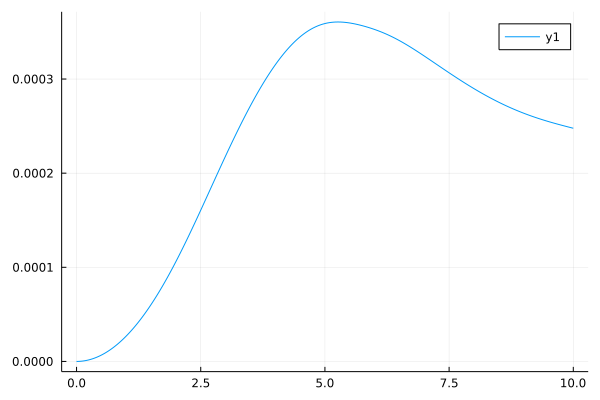

In [24]:
#Plot total energy
using Plots

E = zeros(N)
for k = 1:N
    E[k] = Energy(xhist[:, k])
end

plot(thist,E)